# This notebook's code originates from @LiamClarkZA's python_3d_toolbox and needs to be updated to use the newer functions in calib.calib file!

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares
import cv2
import time

import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
plt.style.use('../configs/mplstyle.yaml')

# from python_3d_toolbox import plotting as ctb_plotting
sys.path.append('./Calib') #NEED TO POINT THIS TO THE Calib MODULE FOLDER!!!
from calib import calib, app, utils, plotting # need to import app before plotting!!!!!!

%load_ext autoreload
%autoreload 2

# Define the params in the cell below. Thereafter, run all!

In [2]:
ROOT_DATA_DIR = "../data/2019_03_09"
DATA_DIR = os.path.join(ROOT_DATA_DIR,f"jules/flick1")
scene_fpath = os.path.join(ROOT_DATA_DIR,'extrinsic_calib/scene_sba.json')

start_frame = 70
end_frame = 170

# DLC p_cutoff - any points with likelihood < dlc_thresh are not trusted in EKF
dlc_thresh = 0.7  # change this only if FTE result is unsatisfactory

# SBA

## Function definitions

In [3]:
def points_2d_df_to_3d(points_2d_df, k_arr, d_arr, r_arr, t_arr, output_3d_point_df_filepath=None, output_video_filepath=None):
    print("Creating initial 3D estimates for optimisation...\n")
    triangulate_func = calib.triangulate_points_fisheye
    pairwise_points_3d_df = calib.get_pairwise_3d_points_from_df(points_2d_df, k_arr, d_arr, r_arr, t_arr, triangulate_func)
    
    print("Performing sparse bundle adjustment...\n")
#     points_3d_df = run_point_bundle_adjustment(pairwise_points_3d_df, points_2d_df, k_arr, d_arr.copy().reshape((-1,4, 1)), r_arr, t_arr)
    points_3d_df = run_point_bundle_adjustment(pairwise_points_3d_df, points_2d_df, k_arr, d_arr, r_arr, t_arr)
    
    if output_3d_point_df_filepath:
        output_3d_point_df_filepath = os.path.expanduser(output_3d_point_df_filepath)
        print("Saving 3D points...")
        if str(output_3d_point_df_filepath).endswith('.csv'):
            points_3d_df.to_csv(output_3d_point_df_filepath)
        elif str(output_3d_point_df_filepath).endswith('.pickle'):
            points_3d_df.to_pickle(output_3d_point_df_filepath)
        elif str(output_3d_point_df_filepath).endswith('.h5'):
            points_3d_df.to_hdf(output_3d_point_df_filepath)
        else:
            print("Unsupported export format")
        print(f"Done. 3D points saved to {output_3d_point_df_filepath}")
#     if output_video_filepath:
#         output_video_filepath = os.path.expanduser(output_video_filepath)
#         print("Creating video...")
#         ctb_plotting.create_animation(points_3d_df, output_video_filepath)
#         print(f"Done. Video saved to {output_video_filepath}")
    
    return points_3d_df


def run_point_bundle_adjustment(points_3d_df, points_2d_df, k_arr, d_arr, r_arr, t_arr, cam_model='fisheye'):
    camera_params = []
    for k,d,r,t in zip(k_arr,d_arr,r_arr,t_arr):
        camera_params.extend(get_camera_params(cam_model, k, d, cv2.Rodrigues(r)[0], t))
    n_cameras = len(k_arr)
    
    camera_params = np.array(camera_params)
    points_3d_df['point_index'] = points_3d_df.index
    points_df = points_2d_df.merge(points_3d_df, how='inner', on=['frame','marker'], suffixes=('_cam',''))
    camera_indices = np.array(points_df['camera'], dtype=np.integer)
    point_indices = np.array(points_df['point_index'], dtype=np.integer)
    points_2d = np.array(points_df[['x_cam', 'y_cam']], dtype=np.float)
    points_3d = np.array(points_3d_df[['x', 'y', 'z']], dtype=np.float)
    n_points = len(points_3d)
    if cam_model == 'standard':
        cost_func = standard_point_cost_func
    elif cam_model == 'fisheye':
        cost_func = fisheye_point_cost_func
    else:
        raise InvalidCameraModelError(f"Camera model not supported: {cam_model}")
    
    x0 = points_3d.ravel()
    f0 = cost_func(x0, camera_params, n_cameras, n_points, camera_indices, point_indices, points_2d)
    plt.plot(f0)
    A = create_point_sba_sparsity_matrix(n_points, camera_indices, point_indices)
    t0 = time.time()
    res = least_squares(cost_func, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-6, method='trf',
                        args=(camera_params, n_cameras, n_points, camera_indices, point_indices, points_2d), max_nfev=100)
    t1 = time.time()
    print("\nOptimization took {0:.0f} seconds\n".format(t1 - t0))
    plt.plot(f0, label="Cost before")
    plt.plot(res.fun, label="Cost after")
    plt.legend()
    plt.show()
    params = res.x
    new_points_3d = params.reshape((n_points, 3))
    new_points_3d_df = points_3d_df.copy()
    new_points_3d_df['x'] = new_points_3d[:, 0]
    new_points_3d_df['y'] = new_points_3d[:, 1]
    new_points_3d_df['z'] = new_points_3d[:, 2]
    return new_points_3d_df


def get_camera_params(cam_model, K, D, R, T):
    #FISHEYE:  [R, R, R, T, T, T, fx, fy, cx, cy, alpha, k1, k2, k3, k4]
    #STANDARD: [R, R, R, T, T, T, fx, fy, cx, cy, k1, k2, p1, p2, k3]

    params = np.empty(15)
    params[0:3] = R.ravel() # R
    params[3:6] = T.ravel() # T
    params[6] = K[0,0]      # fx
    params[7] = K[1,1]      # fy
    params[8] = K[0,2]      # cx
    params[9] = K[1,2]      # cy
    
    if cam_model == 'fisheye':
        params[10] = K[0,1]       # alpha
        params[11:15] = D.ravel() # k1, k2, k3, k4
    elif cam_model == 'standard':
        params[10:15] = D.ravel() # k1, k2, p1, p2, k3
    
    return params


def fisheye_point_cost_func(params, camera_params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    camera_params = camera_params.reshape((n_cameras, 15))
    points_3d = params.reshape((n_points, 3))
    points_2d_reprojected = project_fisheye(points_3d[point_indices], camera_params[camera_indices])

    error = (points_2d_reprojected - points_2d).ravel()
    return error


def project_fisheye(world_pts, cam_params):
    #camera params: [R, R, R, T, T, T, fx, fy, cx, cy, alpha, k1, k2, k3, k4]
    R = cam_params[:,:3]
    T = cam_params[:,3:6]
    fx = cam_params[:,6]
    fy = cam_params[:,7]
    cx = cam_params[:,8]
    cy = cam_params[:,9]
    alpha = cam_params[:,10]
    k1 = cam_params[:,11]
    k2 = cam_params[:,12]
    k3 = cam_params[:,13]
    k4 = cam_params[:,14]
    #do the reprojection - https://docs.opencv.org/4.1.0/db/d58/group__calib3d__fisheye.html
    pts = rotate(world_pts, R)
    pts += T
    a = pts[:,0]/pts[:,2]
    b = pts[:,1]/pts[:,2]
    r = np.sqrt(a**2 + b**2)
    theta = np.arctan(r)
    theta_d = theta*(1 + k1*theta**2 + k2*theta**4 + k3*theta**6 + k4*theta**8)
    x = theta_d/r*a
    y = theta_d/r*b
    u = fx*(x+alpha*y) + cx
    v = fy*y + cy
    return np.dstack((u,v))


def create_point_sba_sparsity_matrix(n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_points * 3
    A = lil_matrix((m, n), dtype=int)
    i = np.arange(camera_indices.size)
    for s in range(3):
        A[2 * i, point_indices * 3 + s] = 1
        A[2 * i + 1, point_indices * 3 + s] = 1
    return A


def rotate(points, rot_vecs):
    # takes numpy arrays of 3D points and corresponding Rodriguez rotation vectors
    # i.e. points[0] = [x,y,z] and camera_params[0] = [R,R,R]
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

## Perform SBA

Creating initial 3D estimates for optimisation...

Found 1483 pairwise points between camera 0 and 1
Found 1194 pairwise points between camera 1 and 2
Found 1031 pairwise points between camera 2 and 3
Found 1211 pairwise points between camera 3 and 4
Found 1265 pairwise points between camera 4 and 5
Performing sparse bundle adjustment...

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5993e+07                                    2.24e+06    
       1              2         6.8726e+06      9.12e+06       1.19e+01       3.73e+05    
       2              3         5.7519e+06      1.12e+06       6.62e+00       4.47e+05    
       3              5         4.9419e+06      8.10e+05       2.48e+00       2.35e+05    
       4              6         4.1672e+06      7.75e+05       4.39e+00       5.17e+05    
       5              8         3.9886e+06      1.79e+05       1.26e+00       3.81e+05    
       6             1

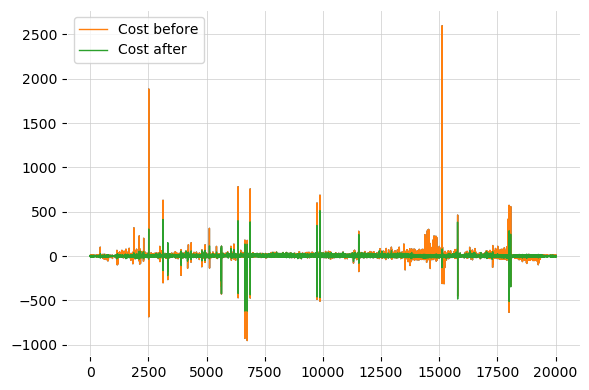

In [4]:
k_arr, d_arr, r_arr, t_arr, _ = utils.load_scene(scene_fpath)
d_arr = d_arr.reshape((-1,4))

df_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.h5')))
points_2d_df = utils.create_dlc_points_2d_file(df_paths)
points_2d_df = points_2d_df[points_2d_df['likelihood']>dlc_thresh]

points_3d_df = points_2d_df_to_3d(points_2d_df, k_arr, d_arr, r_arr, t_arr)#, output_video_filepath=ROOT_DATA_DIR+'/vid.mp4')

## Plot the result!

In [5]:
#PLOT SBA
markers = [
    "l_eye", "r_eye", "nose",
    "neck_base", "spine",
    "tail_base", "tail1", "tail2",
    "l_shoulder", "l_front_knee", "l_front_ankle",
    "r_shoulder", "r_front_knee", "r_front_ankle",
    "l_hip", "l_back_knee", "l_back_ankle",
    "r_hip", "r_back_knee", "r_back_ankle",
    "lure" # this marker must always be at the end of markers array
]

# convert dataframe into 3D joint position vectors for plotting
sba_positions = []
for i in range(start_frame-1, end_frame):
    frame_i_df  = points_3d_df[points_3d_df['frame']==i]
    frame_i_3d_positions=[]
    for marker in markers:
        marker_frame_i_df = frame_i_df[frame_i_df["marker"]==marker]
        marker_frame_i_3d_point = marker_frame_i_df[['x','y','z']].to_numpy()
        # if 3d point vector is empty fill with nans
        if marker_frame_i_3d_point.size == 0:
            marker_frame_i_3d_point = np.empty((1, 3))*np.NaN
        frame_i_3d_positions.extend(marker_frame_i_3d_point)
    sba_positions.append(np.array(frame_i_3d_positions))

# indices correspond to joints in 'markers' variable
lines_idxs = [0,1,0,2,1,2,1,3,0,3,2,3,3,4,4,5,5,6,6,7,3,8,4,8,8,9,9,10,3,11,4,11,11,12,12,13,4,14,5,14,14,15,15,16,4,17,5,17,17,18,18,19]
sba_line_frames = []
for frame_pos in sba_positions:
    sba_line_frames.append(frame_pos[lines_idxs, :])

ca = plotting.Cheetah(sba_positions, sba_line_frames, k_arr,d_arr,r_arr,t_arr)
ca.animation()